In [1]:

seed = 43
import random
random.seed(seed)

import torch
torch.manual_seed(seed)

import numpy as np
np.random.seed(seed)

import matplotlib.pyplot as plt
from datasets.primitive.marked_integer_dataset import MixedSprites3Dataset

from datasets.primitive.shape3 import Shapes3Dataset

dataset_size =2048
test_size = 256

percent = 1.0
train_dataset = MixedSprites3Dataset(dataset_size=dataset_size// 1, p = percent, unary = 0.6)  # create a dataset with 1024 samples
test_dataset = MixedSprites3Dataset(dataset_size=test_size, p = percent, unary = 0.6)  # create a dataset with 128 samples for testing

#train_dataset = Shapes3Dataset(dataset_size = 1024)
#test_dataset = Shapes3Dataset(dataset_size = 128)

corpus = [data[1]["query"] for data in train_dataset]

#from data.collect_corpus import write_vocab, load_corpus, build_vocab
#vocab = build_vocab([] + corpus)
##write_vocab(vocab)


In [2]:
from core.model import MetaLearner
learner = MetaLearner([])
learner.load_ckpt("outputs/checkpoints/prototype")
### load the meta learner from the pretrained-checkpoint
pass


24 19:57:02 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
24 19:57:02 WRN `SearchExecutor` The input domain is empty, creating an empty domain
24 19:57:02 Function red automatically registered.
24 19:57:02 Function green automatically registered.
24 19:57:02 Function blue automatically registered.
24 19:57:02 Function objects automatically registered.
24 19:57:02 Function line automatically registered.
24 19:57:02 Function circle automatically registered.
24 19:57:02 Function start automatically registered.
24 19:57:02 Function end automatically registered.
24 19:57:02 Function on_line automatically registered.
24 19:57:02 Function length automatically registered.
24 19:57:02 Function intersect automatically registered.
24 19:57:02 Function parallel automatically registered.
24 19:57:02 Function perpendicular automatically registered.
24 19:57:02 Function connect_segment automatically registered.
24 19:57:02 Function center automatically registered.
24 19:57:0

# Base Knowledge Learning


24 19:57:03 Filter dataset None: #before=2048, #after=2048.
24 19:57:03 Filter dataset None: #before=256, #after=256.


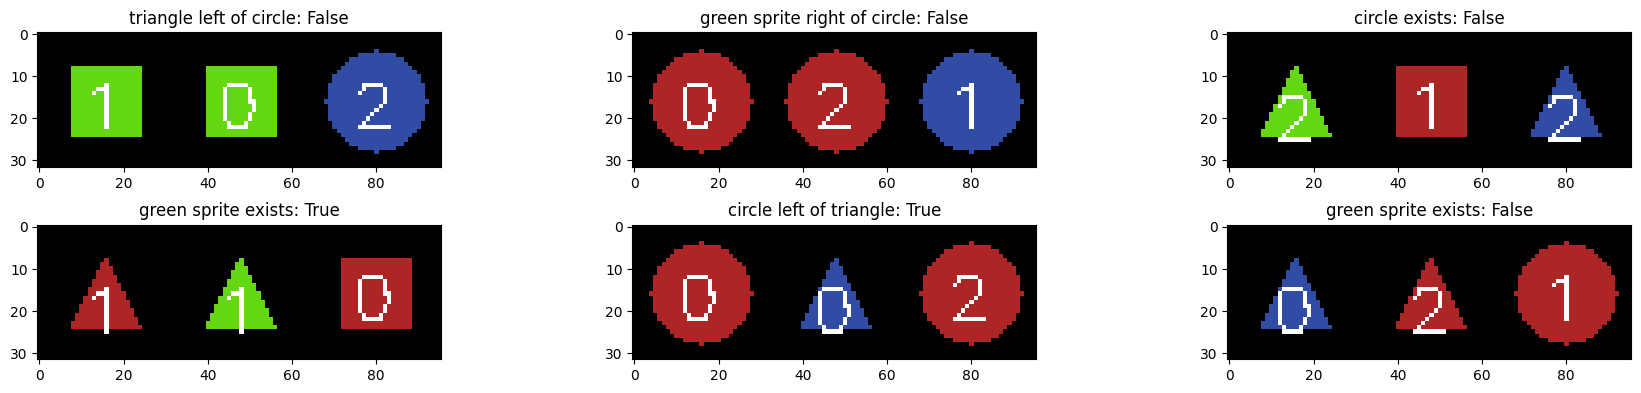

In [3]:
from core.learn import AutoLearnSchedule
from helchriss.logger import set_logger_output_file

valid_types = ["boolean"]
train_logic_dataset = train_dataset.filter(lambda x : x["question_type"] in valid_types)
test_logic_dataset = test_dataset.filter(lambda x : x["question_type"] in valid_types)

# Now let's visualize a few samples from the dataset:
"arithmetic"

plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    #print(train_logic_dataset[i]['image'].permute(1, 2, 0).numpy()[...,::-1].shape)
    plt.imshow(train_logic_dataset[i]['image'].permute(1, 2, 0).numpy())
    plt.title(train_logic_dataset[i]['query'] + ': ' + str(train_dataset[i]['answer']))
    #stprint(train_dataset[i])
plt.tight_layout()
plt.show()



In [4]:

learner.cheat = 1
set_logger_output_file(f"outputs/logs/expr_{dataset_size // 1}.txt")
schedule = AutoLearnSchedule(train_logic_dataset, test_logic_dataset)

#schedule.procedual_train(learner, lr = 1e-3)
#learner.save_ckpt("outputs/checkpoints/logic")

24 19:57:03 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
24 19:57:03 WRN `SearchExecutor` The input domain is empty, creating an empty domain
24 19:57:03 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
24 19:57:03 WRN `SearchExecutor` The input domain is empty, creating an empty domain


red [0 1 1]
red count is : 2
green [0 0 0]
green count is : 0
blue [1 0 0]
blue count is : 1
circle [0 0 1]
circle count is : 1
rectangle [0 0 0]
rectangle count is : 0
triangle [1 1 0]
triangle count is : 2
relations:

left [1 1 0]
right [0 0 0]


/Users/sunyiqi/Documents/GitHub/MetaLearner/domains/logic/fol_domain.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_info = (node_id, son_id, {"weight":float(torch.exp(torch.tensor(-subloss)) )})


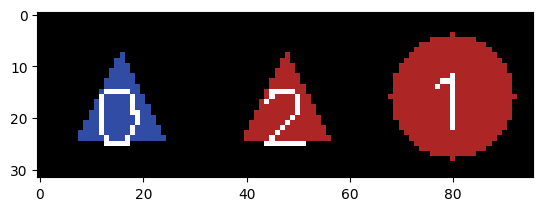

In [5]:
from core.model import MetaLearner
learner = MetaLearner([])
learner.load_ckpt("outputs/checkpoints/logic")

i = 5
img = train_logic_dataset[i]['image']
grounding = {"image": img}
plt.imshow(img.permute(1, 2, 0).numpy())

tags = ["red","green", "blue", "circle", "rectangle", "triangle"]

rels = ["left", "right"]

for tag in tags:
    program = f"filter:Logic(scene:Objects(), {tag}:Objects )"
    measure, _ = learner.executor.additive_evaluation(program, grounding)
    print(tag,(measure.value[:,0].sigmoid() + 0.5).int().detach().numpy())

    program = f"count:Logic( filter:Logic(scene:Objects(), {tag}:Objects ) )"
    measure, _ = learner.executor.additive_evaluation(program, grounding)
    print(f"{tag} count is : {int(measure.value +0.5)}")

print("relations:\n")

tag = "circle:Objects"
for rel in rels:
    program = f"relate:Logic(filter:Logic(scene:Objects(), {tag}), scene:Objects(), {rel}:Objects )"

    measure, _ = learner.executor.additive_evaluation(program, grounding)

    print(rel,(measure.value[:,0].sigmoid() + 0.5).int().detach().numpy())
    

# Continual Learning Concepts
MetaLearner can continually learning new concepts using only language description of the new word and the related domain entries.

24 19:57:04 Filter dataset None: #before=2048, #after=2048.
24 19:57:04 Filter dataset None: #before=256, #after=256.


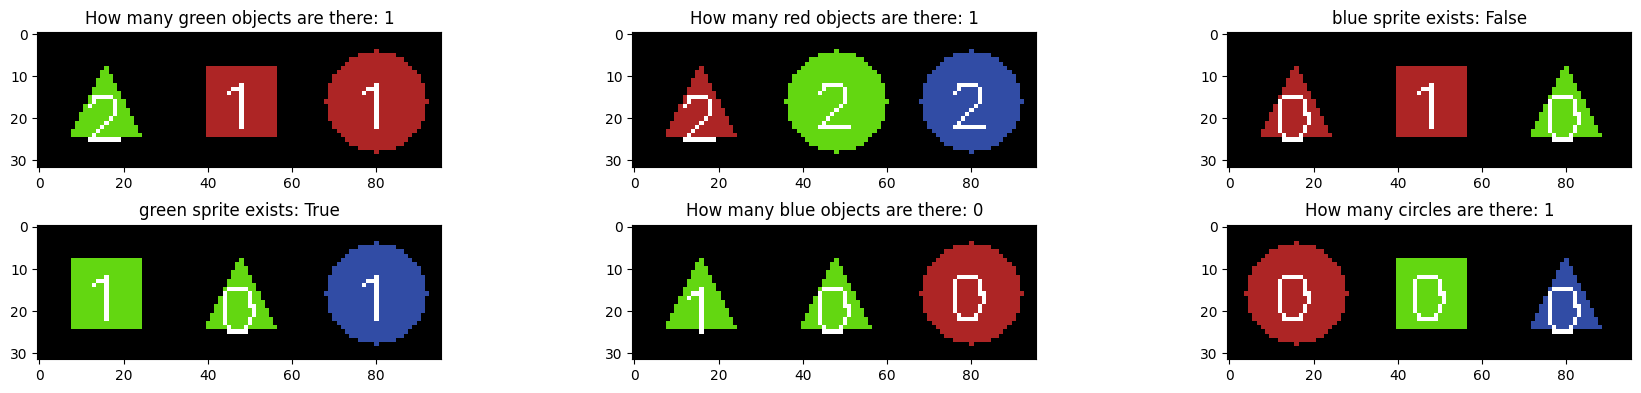

In [6]:
valid_types = ["boolean", "arithmetic"]
percent = 0.3
train_dataset = MixedSprites3Dataset(dataset_size=dataset_size// 1, p = percent, unary = 0.5)  #
test_dataset = MixedSprites3Dataset(dataset_size=test_size, p = percent, unary = 0.5)

train_arith_dataset = train_dataset.filter(lambda x : x["question_type"] in valid_types)
test_arith_dataset = test_dataset.filter(lambda x : x["question_type"] in valid_types)

# Now let's visualize a few samples from the dataset:
"arithmetic"

plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_arith_dataset[i]['image'].permute(1, 2, 0).numpy())
    plt.title(train_arith_dataset[i]['query'] + ': ' + str(train_dataset[i]['answer']))
    #stprint(train_dataset[i])
plt.tight_layout()
plt.show()


In [ ]:
from core.model import MetaLearner
learner = MetaLearner([])
learner.cheat = 1
learner.load_ckpt("outputs/checkpoints/logic")

schedule = AutoLearnSchedule(train_arith_dataset, test_arith_dataset)
#print(learner.executor.constructor.forward_rules)
schedule.procedual_train(learner, lr = 2e-4)
learner.save_ckpt("outputs/checkpoints/max1")

24 19:57:05 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
24 19:57:05 WRN `SearchExecutor` The input domain is empty, creating an empty domain
24 19:57:05 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
24 19:57:05 WRN `SearchExecutor` The input domain is empty, creating an empty domain
24 19:57:07 start to learn the words ['number', 'rectangles', 'red', 'objects', 'right', 'How', 'are', 'circles', 'the', 'triangles', 'green', 'left', 'blue', 'What', 'circle', 'many', 'exists', 'maximum', 'is', 'triangle', 'there', 'of', 'rectangle', 'sprite'], add corpus size 2048
24 19:57:07 unification structure check, eval run
Training epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]24 19:57:08 execution not found for max:Integer([List[Tuple[bool, Embedding[object, 96]]]])
24 19:57:08 update chain : max:Integer -> [List[Tuple[bool, Embedding[object, 96]]]]
/Users/sunyiqi/Documents/GitHub/MetaLearner/domains/logic/fol_domain.py:68: UserWarning: To co

In [ ]:
from core.model import MetaLearner
learner = MetaLearner([])
learner.load_ckpt("outputs/checkpoints/max1")
learner.cheat = 1

i = 3
img = train_arith_dataset[i]['image']
grounding = {"image": img}
plt.imshow(img.permute(1, 2, 0).numpy())

tags = ["red","green", "blue", "circle", "rectangle", "triangle"]

tag1 = "green"
tag2 = "circle"

program = f"plus:Integer(filter:Logic(scene:Objects(), {tag1}:Objects ), filter:Logic(scene:Objects(), {tag2}:Objects ))"

program = f"max:Integer(scene:Objects() )"
#program = f"count:Logic(filter:Logic(scene:Objects(), {tag1}:Objects ))"

from core.model import value_types, UnificationFailure

try:
    measure, _ = learner.executor.additive_evaluation(program, grounding)
except UnificationFailure as e:
    print("Unify:",e.left_structure, value_types(e.right_structure))
    learner.executor.update_chain(e.right_structure, e.left_structure)

print("Progam Value:",program,measure.value)


23 21:52:20 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
23 21:52:20 WRN `SearchExecutor` The input domain is empty, creating an empty domain
23 21:52:20 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
23 21:52:20 WRN `SearchExecutor` The input domain is empty, creating an empty domain


AttributeError: Can't get attribute 'FloatFiller' on <module 'core.metaphors.types' from '/Users/sunyiqi/Documents/GitHub/MetaLearner/core/metaphors/types.py'>